In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

In [11]:
train = pd.read_csv('data/train.csv')
train

,userId,movieId,rating
0,210427,1641,5.0
1,155232,48414,3.5
2,226717,3698,4.0
3,176213,272,3.0
4,68678,423,3.0
...,...,...,...
8710063,43132,3638,3.0
8710064,184361,4701,3.5
8710065,125759,290,3.0
8710066,208890,3686,4.0


In [12]:
test = pd.read_csv('data/test.csv')
test

,userId,movieId,rating
0,51361,2262,4.0
1,43362,2355,4.0
2,254067,4638,2.5
3,90209,4226,4.5
4,204458,61724,4.0
...,...,...,...
2177513,128316,5618,4.5
2177514,225158,575,3.0
2177515,160630,1580,4.0
2177516,231078,247,4.0


In [13]:
movies = pd.read_csv('data/movies.csv')
movies

,Unnamed: 0,id,title,overview,genres,belongs_to_collection,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,vote_average,vote_count,cast,crew,keywords
0,0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","('Animation', 'Comedy', 'Family')",Toy Story Collection,en,21.946943,"('Pixar Animation Studios',)","('United States of America',)",1995-10-30,81.0,"('English',)",Released,NaN,7.7,5415,"('Annie Potts', 'Don Rickles', 'Erik von Dette...","('Ada Cochavi', 'Alan Sperling', 'Alec Sokolow...","('boy', 'boy next door', 'friends', 'friendshi..."
1,1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"('Adventure', 'Family', 'Fantasy')",NaN,en,17.015539,"('Interscope Communications', 'Teitler Film', ...","('United States of America',)",1995-12-15,104.0,"('English', 'Français')",Released,Roll the dice and unleash the excitement!,6.9,2413,"('Adam Hann-Byrd', 'Annabel Kershaw', 'Bebe Ne...","('Chris van Allsburg', 'Greg Taylor', 'James D...","(""based on children's book"", 'board game', 'di..."
2,2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"('Comedy', 'Romance')",Grumpy Old Men Collection,en,11.712900,"('Lancaster Gate', 'Warner Bros.')","('United States of America',)",1995-12-22,101.0,"('English',)",Released,Still Yelling. Still Fighting. Still Ready for...,6.5,92,"('Ann-Margret', 'Burgess Meredith', 'Daryl Han...","('Howard Deutch', 'Jack Keller', 'Mark Steven ...","('best friend', 'duringcreditsstinger', 'fishi..."
3,3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","('Comedy', 'Drama', 'Romance')",NaN,en,3.859495,"('Twentieth Century Fox Film Corporation',)","('United States of America',)",1995-12-22,127.0,"('English',)",Released,Friends are the people who let you be yourself...,6.1,34,"('Angela Bassett', 'Dennis Haysbert', 'Gregory...","('Caron K', 'Deborah Schindler', 'Ezra Swerdlo...","('based on novel', 'chick flick', 'divorce', '..."
4,4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,"('Comedy',)",Father of the Bride Collection,en,8.387519,"('Sandollar Productions', 'Touchstone Pictures')","('United States of America',)",1995-02-10,106.0,"('English',)",Released,Just When His World Is Back To Normal... He's ...,5.7,173,"('BD Wong', 'Diane Keaton', 'Eugene Levy', 'Ge...","('Adam Bernardi', 'Alan Silvestri', 'Albert Ha...","('aging', 'baby', 'confidence', 'contraception..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45424,45454,439050,Subdue,Rising and falling between a man and woman.,"('Drama', 'Family')",NaN,fa,0.072051,(),"('Iran',)",NaN,90.0,"('فارسی',)",Released,Rising and falling between a man and woman,4.0,1,"('Elham Korda', 'Kourosh Tahami', 'Leila Hatami')","('Azadeh Ghavam', 'Babak Ardalan', 'Farshad Mo...","('tragic love',)"
45425,45455,111109,Century of Birthing,An artist struggles to finish his work while a...,"('Drama',)",NaN,tl,0.178241,"('Sine Olivia',)","('Philippines',)",2011-11-17,360.0,"('',)",Released,NaN,9.0,3,"('Angel Aquino', 'Angeli Bayani', 'Bart Guingo...","('Dante Perez', 'Lav Diaz', 'Lav Diaz', 'Lav D...","('artist', 'pinoy', 'play')"
45426,45456,67758,Betrayal,"When one of her hits goes wrong, a professiona...","('Action', 'Drama', 'Thriller')",NaN,en,0.903007,"('American World Pictures',)","('United States of America',)",2003-08-01,90.0,"('English',)",Released,A deadly game of wits.,3.8,6,"('Adam Baldwin', 'Damian Chapa', 'Darrell Dubo...","('C. Courtney Joyner', 'Jeffrey Goldenberg', '...",()
45427,45457,227506,Satan Triumphant,"In a small town live two brothers, one a minis...",(),NaN,en,0.003503,"('Yermoliev',)","('Russia',)",1917-10-21,87.0,(),Released,NaN,0.0,0,"('Aleksandr Chabrov', 'Iwan Mosschuchin', 'Nat...","('Joseph N. Ermolieff', 'Yakov Protazanov')",()


In [31]:
from sklearn.metrics import ndcg_score
from ipywidgets import IntProgress
from IPython.display import display

np.random.seed(9)
test_users = test['userId'].unique()
np.random.shuffle(test_users)
test_users = test_users[:100]

def evaluate(r):
    progress = IntProgress(min=0, max=len(test_users))
    display(progress)

    scores = []
    for user in test_users:
        progress.value += 1

        user_test: np.ndarray = test[test['userId'] == user] \
            .sort_values('rating', ascending=False)['movieId'] \
            .to_numpy()
        
        rankings = r.rank(user, user_test)
        score = ndcg_score(
            [np.arange(len(user_test), 0, -1)], 
            [rankings],
            k=5
        )
        scores.append(score)

    return scores

all_scores = dict()

In [32]:
import trivial_rankers as tr
reload(tr)

vote_based = tr.VoteAverageBasedRanker(movies, train)
weighted_vote_based = tr.WeightedVoteBasedRanker(movies, train)

all_scores |= {
    'Vote': evaluate(vote_based),
    'Weighted Vote': evaluate(weighted_vote_based)
}

IntProgress(value=0)

IntProgress(value=0)

In [33]:
import similarity_based as vbr
reload(vbr)

overview_based = vbr.OverviewBasedRanker(movies, train)
keywords_based = vbr.KeywordsBasedRanker(movies, train)
genre_based = vbr.GenreBasedRanker(movies, train)
cast_based = vbr.CastBasedRanker(movies, train)
crew_based = vbr.CrewBasedRanker(movies, train)
soup_based = vbr.SoupBasedRanker(movies, train)

all_scores |= {
    'Overview': evaluate(overview_based),
    'Keywords': evaluate(keywords_based),
    'Genre': evaluate(genre_based),
    'Crew': evaluate(crew_based),
    'Cast': evaluate(cast_based),
    'Soup': evaluate(soup_based)
}

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

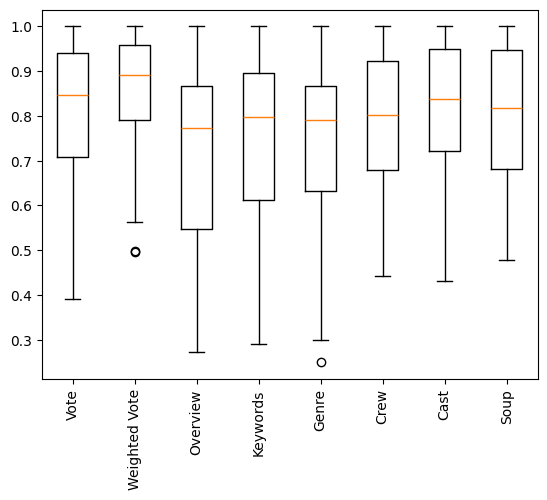

In [34]:
plt.boxplot(all_scores.values(), labels=all_scores.keys())
plt.xticks(rotation=90)
plt.show()

In [35]:
data = pd.DataFrame(all_scores)
data.describe()

,Vote,Weighted Vote,Overview,Keywords,Genre,Crew,Cast,Soup
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.815818,0.862896,0.718450,0.750592,0.748615,0.798157,0.819848,0.804803
std,0.150000,0.123756,0.207956,0.174027,0.179149,0.146603,0.145981,0.144224
min,0.390056,0.495193,0.271653,0.291034,0.249173,0.441529,0.430469,0.478588
25%,0.708446,0.791154,0.548213,0.611604,0.632686,0.678072,0.720735,0.682284
50%,0.847577,0.891929,0.773558,0.798138,0.789998,0.802740,0.836679,0.817494
75%,0.941432,0.957561,0.867503,0.894999,0.867521,0.923193,0.949604,0.946667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
